In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# **tags mapping vector**

In [2]:
question_dtype = {
    'question_id':'int16',
    'tags':'object'
}
questions_data = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv',
                             usecols = question_dtype.keys(), 
                             dtype = question_dtype)

In [3]:
print(questions_data.loc[questions_data.tags.isnull()])
questions_data.tags.fillna('92',inplace=True)

       question_id tags
10033        10033  NaN


In [4]:
tags_set = set()
print(len(questions_data))
for i in range(len(questions_data)):
    tags_set = tags_set.union(questions_data.tags[i].split())
print(tags_set)
print(len(tags_set))

13523
{'26', '161', '98', '155', '71', '49', '14', '79', '16', '7', '125', '175', '142', '174', '167', '23', '171', '51', '128', '103', '170', '24', '118', '153', '105', '5', '90', '143', '12', '4', '56', '80', '46', '3', '140', '34', '104', '122', '77', '144', '176', '181', '124', '41', '137', '66', '135', '33', '82', '107', '36', '92', '132', '47', '148', '91', '68', '75', '54', '58', '20', '55', '35', '183', '165', '39', '100', '52', '172', '76', '180', '45', '78', '50', '60', '112', '94', '29', '1', '157', '18', '182', '95', '113', '2', '163', '15', '115', '158', '109', '83', '173', '81', '168', '74', '110', '21', '114', '162', '129', '186', '87', '65', '127', '138', '169', '28', '6', '130', '99', '106', '44', '72', '40', '187', '86', '38', '179', '84', '120', '123', '17', '108', '185', '139', '19', '0', '70', '93', '13', '150', '126', '88', '164', '57', '147', '32', '154', '97', '136', '101', '10', '73', '116', '134', '152', '145', '146', '85', '121', '89', '156', '48', '159', '69

In [5]:
def gen_vec(row):
    row['vec'] = np.zeros(188)
    index_list = row.tags.split()
    for index_ in index_list:
        row.vec[int(index_)] = 1.0
    return row

questions_data = questions_data.apply(gen_vec, axis='columns')
questions_data.head()

,question_id,tags,vec
0,0,51 131 162 38,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,131 36 81,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,131 101 162 92,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,131 149 162 29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,131 5 162 38,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


# main data reading

In [22]:
train_dtypes_dict = {
    "row_id": "int64",
    #"timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    #"task_container_id": "int16",
    #"user_answer": "int8",
    "answered_correctly": "int8",
    #"prior_question_elapsed_time": "float32", 
    #"prior_question_had_explanation": "boolean"
}

train_data = pd.read_csv("../input/riiid-test-answer-prediction/train.csv",
                         #nrows=10**6,
                         usecols = train_dtypes_dict.keys(),
                         dtype=train_dtypes_dict,
                         #index_col = 0,
                        )

In [23]:
train_data_q = train_data[train_data.content_type_id == 0]
print(len(train_data_q))
print(len(train_data_q.user_id.unique()))
print(train_data_q.head())

99271300
393656
   row_id  user_id  content_id  content_type_id  answered_correctly
0       0      115        5692                0                   1
1       1      115        5716                0                   1
2       2      115         128                0                   1
3       3      115        7860                0                   1
4       4      115        7922                0                   1


In [42]:
#del train_data
train_data_q_sample = train_data_q.sample(n=10**7, random_state=1)

# rate vector for each user

In [9]:
def cal_vec(train_row,ele_dict,num_dict,q_data=questions_data):
    num_dict[train_row.user_id] += q_data.vec[train_row.content_id]
    ele_dict[train_row.user_id] += q_data.vec[train_row.content_id] * train_row.answered_correctly

In [43]:
ele_dict = dict()
num_dict = dict()
for index, row in tqdm(train_data_q_sample.iterrows()):
    if row.user_id in ele_dict.keys():
        cal_vec(row,ele_dict,num_dict)
    else:
        ele_dict[row.user_id] = np.zeros(188)
        num_dict[row.user_id] = np.zeros(188)
        cal_vec(row,ele_dict,num_dict)

10000000it [40:21, 4128.94it/s]


In [44]:
print(len(ele_dict),len(num_dict))
#print(ele_dict[115], num_dict[115])

374802 374802


# prepare for training data

In [45]:
def pre_data(row_data, ele_dict, num_dict, q_data=questions_data):
    m = len(row_data)
    X = np.ones((m,188)) * 0.5
    y = np.zeros(m)
    i = 0
    for index, row in tqdm(row_data.iterrows()):
        mask = q_data.vec[row.content_id]
        if row.user_id in ele_dict:
            X[i] = np.nan_to_num(ele_dict[row.user_id]/num_dict[row.user_id],nan=0.5) * mask
        else:
            X[i] = X[i] * mask
        y[i] = row.answered_correctly
        i = i+1
    return X, y

In [46]:
X_train, y_train = pre_data(train_data_q_sample.sample(n=10**6, random_state=2), ele_dict, num_dict)
print(X_train.shape, y_train.shape)
X_valid, y_valid = pre_data(train_data_q_sample.sample(n=10**5, random_state=29), ele_dict, num_dict)
print(X_valid.shape, y_valid.shape)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
1000000it [05:08, 3238.15it/s]


(1000000, 188) (1000000,)


100000it [00:30, 3251.21it/s]

(100000, 188) (100000,)


# model and training

In [60]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a network with 1 linear unit
model = keras.Sequential([
    layers.Dense(units=1,input_shape=[188], activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss='binary_crossentropy',
    #metrics=['binary_accuracy'],
)

In [61]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=20,
)

Epoch 1/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3528 - val_loss: 0.7825
Epoch 2/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3041 - val_loss: 0.8295
Epoch 3/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3026 - val_loss: 0.8450
Epoch 4/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3023 - val_loss: 0.8522
Epoch 5/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3022 - val_loss: 0.8521
Epoch 6/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3022 - val_loss: 0.8551
Epoch 7/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3021 - val_loss: 0.8563
Epoch 8/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3021 - val_loss: 0.8555
Epoch 9/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.3021 - val_loss: 0.8577
Epoch 10/20
3907/3907 [==============================] - 5s 1ms/step - loss: 0.302

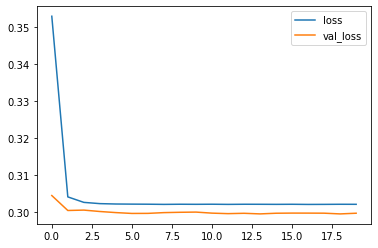

In [50]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
#history_df['loss'].plot();
history_df.loc[:, ['loss', 'val_loss']].plot()

# testing and evaluating

In [51]:
test_sample = train_data_q.sample(n=10**5, random_state=6)
X_test, y_test = pre_data(test_sample, ele_dict, num_dict)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100000it [00:30, 3295.94it/s]


In [56]:
predict_prob = model.predict(X_test)

In [57]:
predict_prob

array([[0.25560287],
       [0.9790405 ],
       [0.9766513 ],
       ...,
       [0.79397476],
       [0.47575742],
       [0.55028087]], dtype=float32)

In [54]:
y_test

array([1., 1., 1., ..., 0., 1., 1.])

In [58]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict_prob)

0.9333748585142458

In [62]:
print(model.layers[0].get_weights()[1])

[-4.504622]
